[source](https://github.com/udacity/deep-reinforcement-learning/blob/master/reinforce/REINFORCE.ipynb)

In [2]:
%reload_ext autoreload
%autoreload 2
import sys
if "../" not in sys.path:
  sys.path.append("../") 
import torch
import numpy as np
import math
from EXITrl.trainer import Trainer
from EXITrl.actor import Actor
from EXITrl.critic import Critic
from EXITrl.helpers import get_simple_model, get_state_action_shape_from_env
import gym

### REINFORCE
- using Monte Carlo
- R. Sutton page 328
- REINFORCE : “REward Increment = Nonnegative Factor × Offset Reinforcement ×Characteristic Eligibility”

![image](../media/REINFORCE.png)

In [3]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class REINFORCE(Trainer):
    def __init__(self, env, num_episodes, gamma, lr):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        model = get_simple_model(state_shape, 16, num_action)
        
        self.actor = Actor(model=model, lr=lr)
        self.gamma = gamma
    
    def _loop(self, episode) -> int:
        done = False
        total_reward, reward = 0, 0
        state = self.env.reset()
        trajectory = []
        for i in range(1000):
            action, log_prob = self.actor.softmax_policy(state)
            _state, reward, done, _ = self.env.step(action)
            trajectory.append((state, reward, done, log_prob))
            total_reward += reward
            state = _state
            if done: break
                
        loss = []
        for t in range(len(trajectory)):
            G = sum([self.gamma**k * reward for k, (state, reward, done, _) in enumerate(trajectory[t:])])
            _, _, _, log_prob = trajectory[t]
            # from Sutton's book said multiply by gamma**t 
            # but from David course no need too 
            # I tried both work
            
            # -log b/c we are trying to maximize reward but the algorithm using Gradient Descent
            # and actually it's not a 'loss' just the gradient of policy just write in term of pytorch loss
            loss.append(self.gamma**t * G * (-log_prob))
        self.actor.update(torch.stack(loss).sum())
        return total_reward
    
    def _policy(self, state):
        action, log_prob = self.actor.softmax_policy(state)
        return action
    
s = REINFORCE(env, 
              num_episodes=500,
              gamma=.99,
              lr=1e-2)
s.train(True)


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 10	Average Score: 18.90 	other{}
Episode 20	Average Score: 20.80 	other{}
Episode 30	Average Score: 22.40 	other{}
Episode 40	Average Score: 25.60 	other{}
Episode 50	Average Score: 47.40 	other{}
Episode 60	Average Score: 41.20 	other{}
Episode 70	Average Score: 38.10 	other{}
Episode 80	Average Score: 46.90 	other{}
Episode 90	Average Score: 52.00 	other{}
Episode 100	Average Score: 55.80 	other{}
Episode 110	Average Score: 58.40 	other{}
Episode 120	Average Score: 65.00 	other{}
Episode 130	Average Score: 83.60 	other{}
Episode 140	Average Score: 70.10 	other{}
Episode 150	Average Score: 104.80 	other{}
Episode 160	Average Score: 140.30 	other{}
Episode 170	Average Score: 121.40 	other{}
Episode 180	Average Score: 173.20 	other{}
Episode 190	Average Score: 194.90 	other{}
Episode 200	Average Score: 121.30 	other{}
Episode 210	Average Score: 92.20 	other{}}
Episode 220	Average S

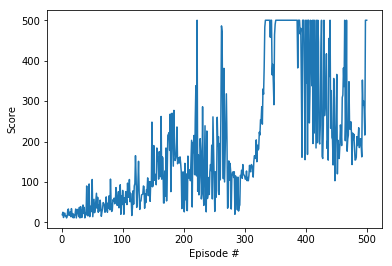

In [4]:
s.plot_rewards()

### REINFORCE with Baseline
![image](../media/REINFORCE_Baseline.png)

In [ ]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class REINFORCE_baseline(Trainer):
    def __init__(self, env, num_episodes, gamma):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        self.actor = Actor(
                        model=get_simple_model(state_shape, 16, num_action), 
                        lr=1e-2)
        self.critic = Critic(
                        model=get_simple_model(state_shape, 16, num_action), 
                        lr=1e-2)
        self.gamma = gamma
        self.loss_value_fn = torch.nn.MSELoss(reduction='sum')
    
    def _loop(self, episode) -> int:
        done = False
        total_reward, reward = 0, 0
        state = self.env.reset()
        trajectory = []
        for i in range(1000):
            action, log_prob = self.actor.softmax_policy(state)
            _state, reward, done, _ = self.env.step(action)
            trajectory.append((state, action, reward, done, log_prob))
            total_reward += reward
            state = _state
            if done: break
                
        td_targets = []
        qs = []
        loss_policy = []
        for t in range(len(trajectory)):
            G = sum([self.gamma**k * reward for k, (state, action, reward, done, log_prob) in enumerate(trajectory[t:])])
            state, action, reward, done, log_prob = trajectory[t]
            td_error = G - self.critic.get_value(state)[action]
            td_targets.append(G)
            qs.append(self.critic.get_value(state)[action])
            loss_policy.append(self.gamma**t * td_error * (-log_prob))
            
        self.actor.update(torch.stack(loss_policy).sum())
        self.critic.update(
            self.loss_value_fn(
                torch.Tensor(td_targets), 
                torch.stack(qs)
            )
        )
        return total_reward
    
    def _policy(self, state):
        action, log_prob = self.actor.softmax_policy(state)
        return action
    
s = REINFORCE_baseline(env, 
              num_episodes=500,
              gamma=.99)
s.train(True)


/Users/epinyoanun/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 10	Average Score: 18.50 	other{}
Episode 20	Average Score: 20.60 	other{}
Episode 30	Average Score: 24.10 	other{}
Episode 40	Average Score: 30.70 	other{}
Episode 50	Average Score: 34.70 	other{}
Episode 60	Average Score: 40.30 	other{}
Episode 70	Average Score: 59.00 	other{}
Episode 80	Average Score: 63.20 	other{}
Episode 90	Average Score: 90.90 	other{}
Episode 100	Average Score: 104.20 	other{}
Episode 110	Average Score: 143.90 	other{}
Episode 120	Average Score: 182.20 	other{}
Episode 130	Average Score: 209.70 	other{}
Episode 140	Average Score: 153.80 	other{}
Episode 150	Average Score: 156.00 	other{}
Episode 160	Average Score: 178.50 	other{}
Episode 170	Average Score: 369.90 	other{}
Episode 180	Average Score: 352.30 	other{}
Episode 190	Average Score: 500.00 	other{}
Episode 200	Average Score: 482.20 	other{}
Episode 210	Average Score: 471.40 	other{}
Episode 220	Aver

In [ ]:
s.plot_rewards()

### Actor-Critic
![image](../media/Actor-Critic.png)
[source](https://github.com/pytorch/examples/blob/6c51ca5a614cfdbdcd4e8c3e70321c5f6defb177/reinforcement_learning/actor_critic.py)

In [ ]:
try: env.close()
except: pass
env = gym.make('CartPole-v1')

class REINFORCE(Trainer):
    def __init__(self, env, num_episodes, gamma, lr):
        super().__init__(env, num_episodes)
        state_shape, num_action = get_state_action_shape_from_env(env)
        
        model = get_simple_model(state_shape, 16, num_action)
        
        self.actor = Actor(model=model, lr=lr)
        self.gamma = gamma
    
    def _loop(self, episode) -> int:
        done = False
        total_reward, reward = 0, 0
        state = self.env.reset()
        trajectory = []
        for i in range(1000):
            action, log_prob = self.actor.softmax_policy(state)
            _state, reward, done, _ = self.env.step(action)
            trajectory.append((state, reward, done, log_prob))
            total_reward += reward
            state = _state
            if done: break
                
        loss = []
        for t in range(len(trajectory)):
            G = sum([self.gamma**k * reward for k, (state, reward, done, _) in enumerate(trajectory[t:])])
            _, _, _, log_prob = trajectory[t]
            # from Sutton's book said multiply by gamma**t 
            # but from David course no need too 
            # I tried both work
            
            # -log b/c we are trying to maximize reward but the algorithm using Gradient Descent
            # and actually it's not a 'loss' just the gradient of policy just write in term of pytorch loss
            loss.append(self.gamma**t * G * (-log_prob))
        self.actor.update(torch.stack(loss).sum())
        return total_reward
    
    def _policy(self, state):
        action, log_prob = self.actor.softmax_policy(state)
        return action
    
s = REINFORCE(env, 
              num_episodes=500,
              gamma=.99,
              lr=1e-2)
s.train(True)
